In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler

from sklearn.calibration import LabelEncoder
from sklearn.discriminant_analysis import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Set random seed
seed = 42

In [51]:
# Read cleaned data from csv
df = pd.read_csv('input/movie_data_tmbd_cleaned.csv', sep='|')


In [52]:
# Print info about the data
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 8784 non-null   int64  
 1   budget                8784 non-null   int64  
 2   genres                8780 non-null   object 
 3   original_language     8784 non-null   object 
 4   overview              8763 non-null   object 
 5   popularity            8784 non-null   float64
 6   production_companies  8618 non-null   object 
 7   production_countries  8737 non-null   object 
 8   revenue               8784 non-null   int64  
 9   runtime               8784 non-null   float64
 10  spoken_languages      8768 non-null   object 
 11  status                8784 non-null   object 
 12  tagline               6912 non-null   object 
 13  title                 8784 non-null   object 
 14  video                 8784 non-null   int64  
 15  vote_average         

# Scoring prediction

In [53]:
X = df.drop(columns=['vote_average', 'category'])
Y = df['category']
print(df)


      adult     budget                                          genres  \
0         0  200000000       Adventure,Action,Thriller,Science Fiction   
1         0  130000000                Science Fiction,Action,Adventure   
2         0  165000000                Action,Adventure,Science Fiction   
3         0  120000000                Action,Adventure,Science Fiction   
4         0   78000000   Fantasy,Action,Crime,Science Fiction,Thriller   
...     ...        ...                                             ...   
8779      0          0  Mystery,Animation,Comedy,Family,Action,Fantasy   
8780      0          0                                     Documentary   
8781      0          0                                    Comedy,Crime   
8782      0          0                                    Action,Crime   
8783      0          0                                    Drama,Comedy   

     original_language                                           overview  \
0                   en  For centur

In [54]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)


print("Training set size: ", len(X_train))
print("Test set size: ", len(X_test))

Training set size:  7027
Test set size:  1757


# Feature encoding

In [55]:
#print(X.info())

In [56]:
#print(X.head())

In [57]:
from sklearn.pipeline import FunctionTransformer


numerical_features = ['budget', 'revenue', 'popularity', 'runtime', 'vote_count', 'release_year', 'release_month', 'release_day']
categorical_features = ['original_language', 'status']
boolean_features = ['adult', 'video']
text_features = ['overview', 'tagline']
list_based_features = ['genres', 'production_companies', 'production_countries', 'cast', 'directors']

# 1. Numerical transformer: Impute missing values and standardize
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2. Categorical transformer: Impute missing values and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 3. Boolean transformer: Ensure 0/1 values
boolean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# 4. Text transformer: Use TF-IDF for text columns
text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=100))  # Adjust max_features as needed
])

# 5. List-based transformer: Convert list of items into count vectors (like multi-hot encoding)
def list_to_str(column):
    return column.apply(lambda x: ','.join(x) if isinstance(x, list) else '')

list_transformer = Pipeline(steps=[
    ('to_string', FunctionTransformer(list_to_str, validate=False)),
    ('countvec', CountVectorizer(tokenizer=lambda x: x.split(','), max_features=100))  # Adjust max_features as needed
])

# Combine all transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('bool', boolean_transformer, boolean_features),
        ('overview', text_transformer, 'overview'),
        ('tagline', text_transformer, 'tagline'),
        ('genres', list_transformer, 'genres'),
        ('production_companies', list_transformer, 'production_companies'),
        ('production_countries', list_transformer, 'production_countries'),
        ('cast', list_transformer, 'cast'),
        ('directors', list_transformer, 'directors')
    ]
)



# Transparent Models

## Decision Tree

### C4.5 Algorithm

Functions needed to help calculate the Information Gain Ratio to be used with the tree. 


In [58]:
def entropy(target_col):
    elements, counts = np.unique(target_col, return_counts=True)
    #Portion of 'bad' = counts['bad']/np.sum(counts)
    entropy_value = np.sum([(-counts[i]/np.sum(counts)) * np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
    return entropy_value

In [59]:
# 'category' has 4 possible values, so Entropy can range from 0 (perfectly pure, all values in one class) to 2 (all classes represented equally in the same number each)
e = entropy(df['category'])
elements, counts = np.unique(df['category'], return_counts=True)
print(e)
print(elements)
print(counts)

2.0
['bad' 'good' 'great' 'mediocre']
[2196 2196 2196 2196]


In [60]:
#Information Gain -> the expected reduction in entropy (more proximate to 0 = more pure = reached decision) caused by partitioning the dataset according to split_attribute_name
#                 -> the amount of information gained by spliting the data using split_attribute_name
#                 -> higher values are better
def info_gain(data, split_attribute_name, target_name='category'):
    total_entropy = entropy(data[target_name]) #entropy(df['category'])
    
    # All possible values for the splitting attribute
    values, counts = np.unique(data[split_attribute_name].astype(str), return_counts=True)
    
    weighted_entropy = np.sum([(counts[i]/np.sum(counts)) * entropy(data.where(data[split_attribute_name].astype(str) == values[i]).dropna()[target_name]) for i in range(len(values))])
    
    information_gain = total_entropy - weighted_entropy
    return information_gain

In [61]:
#igainex1 = info_gain(df, 'budget')
#print(igainex1)

#igainex2 = info_gain(df, 'popularity')
#print(igainex2)

#igainex3 = info_gain(df, 'spoken_languages')
#print(igainex3)

In [62]:
#Information Gain Ratio  ->  ratio of information gain to the intrinsic information
#                        -> reduce a bias towards multi-valued attributes by taking the number and size of branches into account when choosing an attribute, biases the decision tree against considering attributes with a large number of distinct values (ex: ID would lead to maximum purity)
#                        -> higher values are better
def info_gain_ratio(data, split_attribute_name, target_name='category'):
    information_gain = info_gain(data, split_attribute_name, target_name)
    
    # Split information = Intrinsic value  -> is a positive number that describes the potential worth of splitting a branch from a node. 
    # This in turn is the intrinsic value that the spliting attribute possesses and will be used to remove the bias in the information gain ratio calculation. (src: Wikipedia)
    values, counts = np.unique(data[split_attribute_name].astype(str), return_counts=True)
    split_information = np.sum([(-counts[i]/np.sum(counts)) * np.log2(counts[i]/np.sum(counts)) for i in range(len(values))])
    
    # Avoidinge division by zero
    if split_information == 0:
        return 0
    
    # Gain ratio is the information gain divided by intrinsic value
    return information_gain / split_information

In [63]:
print(df.columns)

Index(['adult', 'budget', 'genres', 'original_language', 'overview',
       'popularity', 'production_companies', 'production_countries', 'revenue',
       'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'cast', 'directors', 'release_year',
       'release_month', 'release_day', 'category'],
      dtype='object')


In [64]:
#igrex1 = info_gain_ratio(df, 'budget')
#print(igrex1)

#igrex2 = info_gain_ratio(df, 'popularity')
#print(igrex2)

#igrex3 = info_gain_ratio(df, 'spoken_languages')
#print(igrex3)


In [65]:
# C4.5 Recursive Algorithm to build the Decision Tree
def c45_tree(data, original_data, features, target_name='category', parent_node_class=None):
    
    # Base case 1: If all target values are the same, return that class
    if len(np.unique(data[target_name])) <= 1:
        return np.unique(data[target_name])[0]
    
    # Base case 2: If dataset is empty, return the class of the parent node
    elif len(data) == 0:
        return parent_node_class
    
    # Base case 3: If no more features to split on, return the majority class of the current node
    elif len(features) == 0:
        return parent_node_class
    
    # Set the current node’s class to the majority class in this subset of data
    current_majority_class = np.unique(data[target_name])[np.argmax(np.unique(data[target_name], return_counts=True)[1])]
    
    # If parent_node_class was None, initialize it with the majority class of the entire data
    if parent_node_class is None:
        parent_node_class = current_majority_class
    
    # Calculate gain ratios for all features and select the feature with the highest gain ratio
    gain_ratios = [info_gain_ratio(data, feature, target_name) for feature in features]
    best_feature_index = np.argmax(gain_ratios)
    best_feature = features[best_feature_index]
    
    # If the best gain ratio is 0 (no information gain), return the majority class
    if gain_ratios[best_feature_index] == 0:
        return current_majority_class
    
    tree = {best_feature: {}}
    
    # For each value of the best feature, split the data and recursively build the subtree
    for value in np.unique(data[best_feature].astype(str)):
        sub_data = data.loc[data[best_feature].astype(str) == value]
        
        # Recursively build the subtree with updated features list (excluding the best feature)
        subtree = c45_tree(
            sub_data, original_data, 
            [f for f in features if f != best_feature], 
            target_name, 
            current_majority_class  
        )
        tree[best_feature][value] = subtree
    
    return tree


In [66]:
#featureList = df.columns[df.columns.isin(['category', 'vote_average']) == False].tolist()
featureList = df.columns[df.columns.isin(['category', 'vote_average']) == False].tolist()


In [67]:
print("X_train columns:", X_train.columns)
print("X_test columns:", X_test.columns)

print(featureList)
print(Y_train)


X_train columns: Index(['adult', 'budget', 'genres', 'original_language', 'overview',
       'popularity', 'production_companies', 'production_countries', 'revenue',
       'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_count', 'cast', 'directors', 'release_year', 'release_month',
       'release_day'],
      dtype='object')
X_test columns: Index(['adult', 'budget', 'genres', 'original_language', 'overview',
       'popularity', 'production_companies', 'production_countries', 'revenue',
       'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_count', 'cast', 'directors', 'release_year', 'release_month',
       'release_day'],
      dtype='object')
['adult', 'budget', 'genres', 'original_language', 'overview', 'popularity', 'production_companies', 'production_countries', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'vote_count', 'cast', 'directors', 'release_year', 'release_month', '

In [68]:
print(pd.concat([X_train, Y_train], axis=1).columns)

Index(['adult', 'budget', 'genres', 'original_language', 'overview',
       'popularity', 'production_companies', 'production_countries', 'revenue',
       'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_count', 'cast', 'directors', 'release_year', 'release_month',
       'release_day', 'category'],
      dtype='object')


In [69]:
#c45tree = c45_tree(df, df, featureList)
#c45tree = c45_tree(X_train, X_train, featureList)
#c45tree = c45_tree(pd.concat([X_train, Y_train], axis=1), pd.concat([X_train, Y_train], axis=1), featureList)

c45tree = c45_tree(
    pd.concat([X_train, Y_train], axis=1),
    pd.concat([X_train, Y_train], axis=1),
    featureList
)


print(c45tree)
#~5min

{'video': {'0': {'tagline': {'"An artistic masterpiece and also a joy to watch."': 'great', '"Just The Facts."': 'mediocre', "'S Wonderful! 'S Marvelous!": 'good', "'Tis about to get medieval up in here.": 'mediocre', "'Twas the Fight Before Christmas...": 'mediocre', '(n. One who has returned, as if from the dead.)': 'great', '-If anyone asks.': 'good', "... It's no fairy tale": 'great', '... The Suspense Filled Story of 7 Bullets!': 'great', '... and hell followed with him.': 'good', '... come prepared!': 'bad', "... once you're on, you'll want to get off...": 'bad', '...An act of vengeance': 'mediocre', "...I'll never tell.": 'mediocre', '...a motion picture for all times!': 'great', '...all it takes is a little confidence.': 'great', '...an army of one.': 'great', '...being friends has its benefits?': 'good', '...the most devastating killing machine ever built... his job... steal it!': 'mediocre', '...the scars run deep.': 'good', "...they're Singing and Dancing in the Streets": 'g

In [70]:
def tree_predict(tree, sample, parent_node_class=None):
    # If the current tree node is a leaf (a class value), return that class
    if not isinstance(tree, dict):
        return tree

    # The current feature to split on
    feature = next(iter(tree))

    # Get the value of this feature in the current sample
    feature_value = sample.get(feature, None)

    # Find the subtree that matches this feature value
    subtree = tree[feature].get(feature_value, None)

    # If no subtree matches, try using the parent node's majority class
    if subtree is None:
        return parent_node_class

    # Recurse into the subtree, passing the parent class down the tree
    return tree_predict(subtree, sample, parent_node_class)


In [71]:
print(X_test.columns) 

Index(['adult', 'budget', 'genres', 'original_language', 'overview',
       'popularity', 'production_companies', 'production_countries', 'revenue',
       'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_count', 'cast', 'directors', 'release_year', 'release_month',
       'release_day'],
      dtype='object')


In [72]:

#parent_class = df['category'].mode()[0]


#Y_pred = [tree_predict(c45tree, sample, parent_class) for _, sample in X_test.iterrows()]

#Y_pred_encoded = label_encoder.transform(Y_pred)

# Generate predictions for the test set
parent_class = Y_train.mode()[0]  # Use majority class as fallback
Y_pred = [tree_predict(c45tree, sample, parent_class) for _, sample in X_test.iterrows()]

# Encode predictions for evaluation
Y_pred_encoded = label_encoder.transform(Y_pred)

print("Majority class (fallback):", parent_class)
print("Predictions:", Y_pred_encoded)


Majority class (fallback): great
Predictions: [2 2 2 ... 2 2 2]


Accuracy:  0.23847467273762094
['bad', 'good', 'great', 'mediocre']
category
good        457
bad         454
mediocre    427
great       419
Name: count, dtype: int64


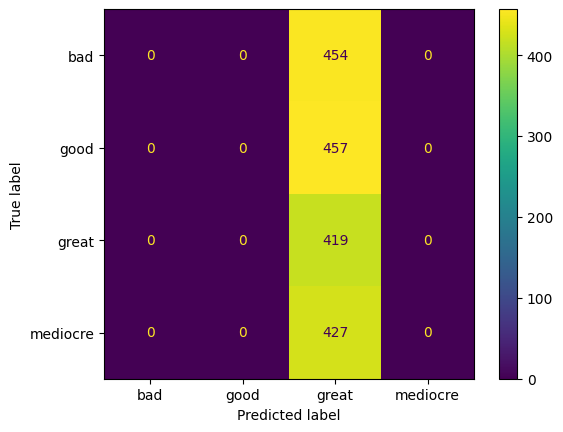

In [73]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

accuracy = accuracy_score(Y_test_encoded, Y_pred_encoded)
print("Accuracy: ", accuracy)


print(sorted(Y_test.unique()))
print(Y_test.value_counts())


cm = confusion_matrix(Y_test_encoded, Y_pred_encoded)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()
